In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


In [2]:
def dgp(n_obs=10000, n_vars=5, seed=None):
    """
    Generate a synthetic dataset with n_vars variables and n_obs observations,
    where each variable contains a constant value: x2 = 2, x3 = 3, ..., x{n_vars+1} = n_vars+1.

    Args:
        n_obs (int): Number of observations (rows).
        n_vars (int): Number of variables (columns).
        seed (int or None): Random seed (not used here since data is deterministic).

    Returns:
        pd.DataFrame: Generated dataset.
    """
    values = np.arange(2, 2 + n_vars)  # [2, 3, ..., n_vars + 1]
    data = np.tile(values, (n_obs, 1))  # Repeat each value across n_obs rows
    columns = [f"x{i+2}" for i in range(n_vars)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [3]:
df = dgp(n_obs=100, n_vars=10, seed=42)
# Get min_vals and max_vals as torch tensors
quantiles = df.quantile([0.025, 0.975])
min_vals = quantiles.loc[0.025].values.astype(np.float32)
max_vals = quantiles.loc[0.975].values.astype(np.float32)

print(df.head())

   x2  x3  x4  x5  x6  x7  x8  x9  x10  x11
0   2   3   4   5   6   7   8   9   10   11
1   2   3   4   5   6   7   8   9   10   11
2   2   3   4   5   6   7   8   9   10   11
3   2   3   4   5   6   7   8   9   10   11
4   2   3   4   5   6   7   8   9   10   11


In [4]:
# train
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 80, Validation size: 10, Test size: 10


## ✅ CI / LS / CS Combination Test Checklist (≥3 Variables)

| Combination         | Tested | Works? | Comments                           |
|---------------------|--------|--------|------------------------------------|
| CI, LS, LS          | ✅    | ✅    |                                    |
| CI, LS, CS          | ✅    | ✅    |                                    |
| CI, CS, CS          | ✅    | ✅    |                                    |
| LS, LS, LS          | ✅    | ✅    |                                    |
| LS, LS, CS          | ✅    |  ✅    |                                    |
| LS, CS, CS          | ✅    | ✅    |                                    |
| CS, CS, CS          | [ ]    | [ ]    |                                    |

<!-- CI-CI-* should be tested last -->
## ⚠️ CI-CI-* Combinations (Not Currently and should be eg CI(x2 x3))

| Combination         | Tested | Works? | Comments                           |
|---------------------|--------|--------|------------------------------------|
| CI, CI, LS          | [ ]    | [ ]    |                                    |
| CI, CI, CS          | [ ]    | [ ]    |                                    |
| CI, CI, CI          | [ ]    | [ ]    |                                    |


the problem is that i need to specify a simple intercept but this is actually not needed, for source node sit works but it should aslo have a simple intecepts if there are only lS and cs in the model

there cannot be and edge with SI!

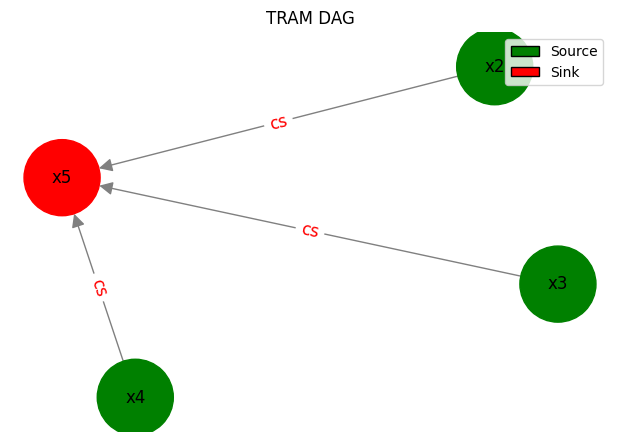

In [5]:
data_type = {'x2': 'cont','x3': 'cont','x4': 'cont','x5': 'cont'}
adj_matrix = np.array([
    ["0",  "0",  "0",  "cs"],   # x1 → x2 (ci), x1 → x3 (ls)
    ["0",  "0",  "0",  "cs"],   # x2 → x3 (cs)
    ["0",  "0",  "0",  "cs"],  # x3 → x4 (ls)
    ["0",  "0",  "0",   "0"],   # x4
], dtype=object)

plot_seed = 42
plot_dag(adj_matrix, data_type, seed=plot_seed)

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


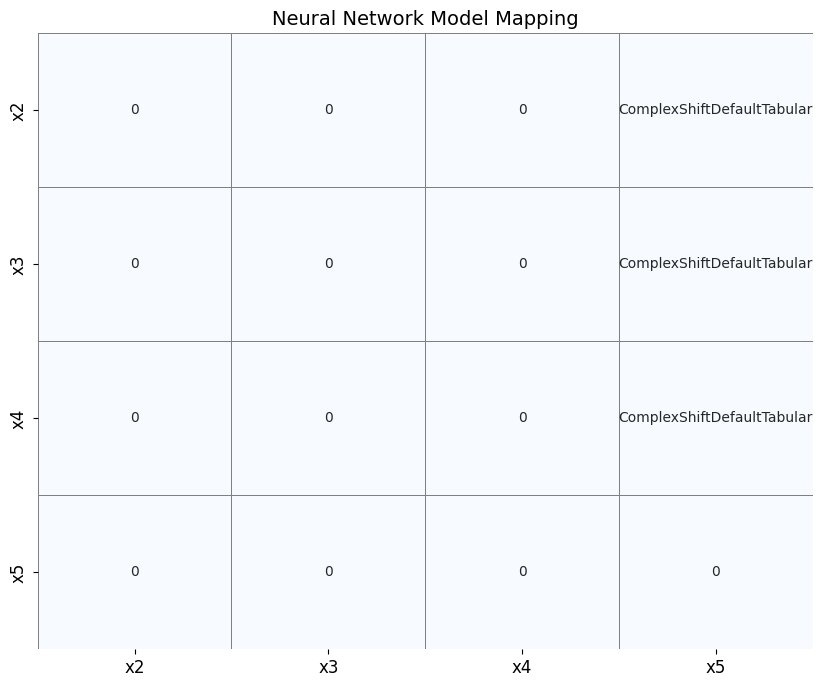

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

In [7]:
conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()
    conf_dict[node]['max']=max_vals[i].tolist()

conf_dict

{'x2': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 2.0,
  'max': 2.0},
 'x3': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 3.0,
  'max': 3.0},
 'x4': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 4.0,
  'max': 4.0},
 'x5': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x2', 'x3', 'x4'],
  'parents_datatype': {'x2': 'cont', 'x3': 'cont', 'x4': 'cont'},
  'transformation_terms_in_h()': {'x2': 'cs', 'x3': 'cs', 'x4': 'cs'},
  'transformation_term_nn_models_in_h()': {'x2': 'ComplexShiftDefaultTabular',
   'x3':

In [8]:
DEV_TRAINING=True
train_list=['x2','x3','x4','x5']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 4112
epochs = 1   # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [9]:
# For each NODE 
for node in conf_dict:

    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')

    ########################## 0. Skip nodes ###############################
    if node not in train_list:
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)

    ########################## 2. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 3. Min/Max Tensor ############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 4. Optimizer & Scheduler #####################
    optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.001, eps=1e-8, weight_decay=1e-2)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 5. Train for One Epoch #######################
    tram_model.train()
    total_train_loss = 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x, device=device)
        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        loss = contram_nll(y_pred, y, min_max=min_max)
        loss.backward()
        optimizer.step()
        if use_scheduler:
            scheduler.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"[{node}] Training loss: {avg_train_loss:.4f}")

    ########################## 6. Validate for One Epoch ####################
    tram_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            y = y.to(device)
            int_input, shift_list = preprocess_inputs(x, device=device)
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            loss = contram_nll(y_pred, y, min_max=min_max)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"[{node}] Validation loss: {avg_val_loss:.4f}")



----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)


>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
[x2] Training loss: nan
[x2] Validation loss: nan

----*----------*-------------*--------------- Node: x3 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
[x3] Training loss: nan
[x3] Validation loss: nan

----*----------*-------------*--------------- Node: x4 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
[x4] Training loss: nan
[x4] Validation loss: nan

----*----------*-------------*--------------- Node: x5 ------------*-----------------*-------------------*--


In [10]:
tram_model

TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0-2): 3 x ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=32, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=32, out_features=32, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

In [14]:
next(iter(train_loader))

[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1.]),
  tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
          2., 2., 2., 2., 2., 2., 2., 2.]),
  tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
          3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
          

In [12]:
conf_dict

{'x2': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 2.0,
  'max': 2.0},
 'x3': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 3.0,
  'max': 3.0},
 'x4': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 4.0,
  'max': 4.0},
 'x5': {'Modelnr': 3,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x2', 'x3', 'x4'],
  'parents_datatype': {'x2': 'cont', 'x3': 'cont', 'x4': 'cont'},
  'transformation_terms_in_h()': {'x2': 'cs', 'x3': 'cs', 'x4': 'cs'},
  'transformation_term_nn_models_in_h()': {'x2': 'ComplexShiftDefaultTabular',
   'x3':